In [1]:
set.seed(1234)   
# libraries
library(ggplot2)

## Question 2 Neural Network’s Decision Boundary

### 1. load train and test data and visualize train data

In [2]:
# reading the data function
read.data <- function(file.name, scaling=FALSE) {
    data <- read.csv(file=file.name,head=TRUE,sep=",")
    data <- data[complete.cases(data),] # removes rows with NA values
    D <- ncol(data) # number of column
    x = data[,-D]  # remove last column (remove label)
    y = data[,D]  # only last column (only label)

    if (isTRUE(scaling)) {
        x = scale(x)
        y = scale(y)
    }
    return (list('x' = x, 'y' = y))
}

# error function
error.rate <- function(Y1, T1){
    if (length(Y1)!=length(T1)){
        stop('error.rate: size of true lables and predicted labels mismatch')
    }
    return (sum(T1!=Y1)/length(T1))
}

In [3]:
# read data
train <- read.data("Task2B_train.csv")
test <- read.data("Task2B_test.csv")

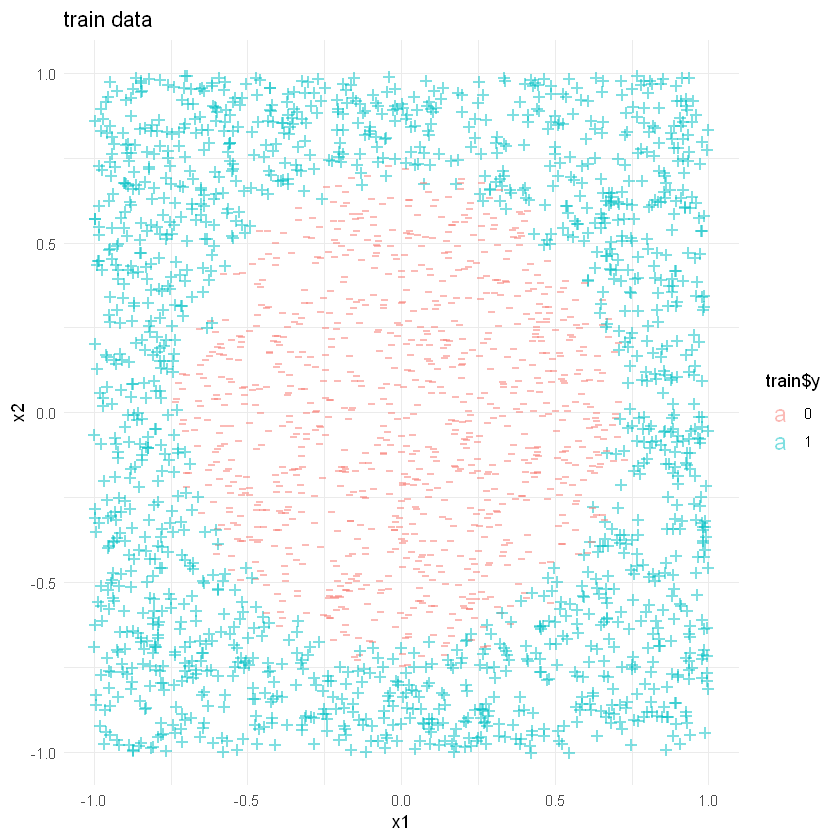

In [4]:
# change label to factor
train$y <- as.factor(train$y)
# visualize data
ggplot(data=train$x, aes(x=x1, y=x2, color= train$y, label=ifelse(train$y== 0, '-', '+'))) +
    geom_text(size = 5, alpha=0.5) +
    ggtitle ('train data') +
    theme_minimal()

### 2. Perceptron with 0.1 and 0.9 learning rate

In [5]:
# prediction function
perceptron.predict <- function(Phi, W){
    return(ifelse(Phi%*%W>=0, +1, -1))
}

# is it a misclassification? if yes, update the weight vector
is.a.miss <- function(Phi, W, T1){
    return((W%*%Phi)*T1<0)
}

# Perceptron Build function
perceptron.build <- function(X1, T1, eta=0.01, epsilon=0.001, tau.max=100, plotting=FALSE){
    # check input data
    if (length(unique(T1))!=2){
    stop("Perceptron: The input data is not a binary classification problem.")
    }
    # check label
    if (all(sort(unique(T1)) != c(-1, 1))) {
    stop("Perceptron: The labels are not (-1, +1).")
    }
    
    # initialize values
    N1 <- nrow(X1) # number of row
    Phi <- as.matrix(cbind(1, X1)) # add a column of 1 as phi_0
    W <- matrix(NA,nrow=tau.max, ncol=ncol(Phi)) # Empty Weight vector
    W[1,] <- 2*runif(ncol(Phi))-1 # Random initial values for weight vector
    error.rec <- matrix(NA,nrow=tau.max, ncol=1) # Placeholder for errors
    error.rec[1] <- error.rate(perceptron.predict(Phi, W[1,]), T1) # record error for initial weights
    tau <- 1 # iteration counter 
    terminate <- FALSE # termination status

    while(!terminate){
        # resuffling train data and associated labels:
        indx <- sample(1:N1, replace = FALSE)
        Phi <- Phi[indx,]
        T1 <- T1[indx]

        for (i in 1:N1){
            if (tau >= tau.max) {break}
            # look for missclassified samples
            if (is.a.miss(Phi[i,], W[tau,], T1[i])) {
                tau <- tau +1                                 # update tau counter
                W[tau,] <- W[tau-1,] + eta * Phi[i,] * T1[i]  # update the weights
                error.rec[tau] <- error.rate(perceptron.predict(Phi, W[tau,]), T1)# update the records
                eta = eta * 0.99                                 # decrease eta
                
            }
        }

        # recalculate termination conditions
        terminate <- tau >= tau.max | (abs(error.rec[tau] - error.rec[tau-1]) <= epsilon )
        
    }
    if (plotting){
        plot(error.rec[complete.cases(error.rec),], xlab = 'tau', ylab = 'error', main = 'Perceptron')
    }
    W <- W[complete.cases(W),]  # cut the empty part of the matrix (when the loop stops before tau == tau.max)
    return(W[nrow(W),])         # return the last wight vector
}

In [6]:
# change label from 0,1 to -1,1
train$y <- as.character(train$y)
train$y[train$y == 0 ] <- -1
train$y <- as.numeric(train$y) # to numeric so it can be used in caluclation

[1] 6.958176e-07 6.561128e-06 5.630767e-06

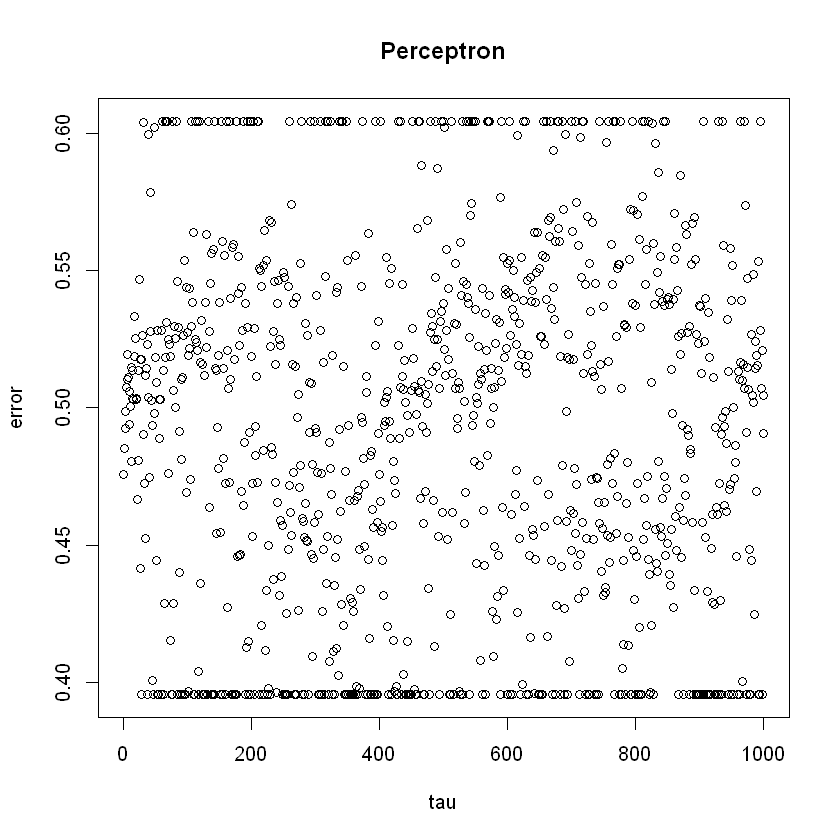

[1] -1.826793e-05  4.014184e-06 -3.983180e-05

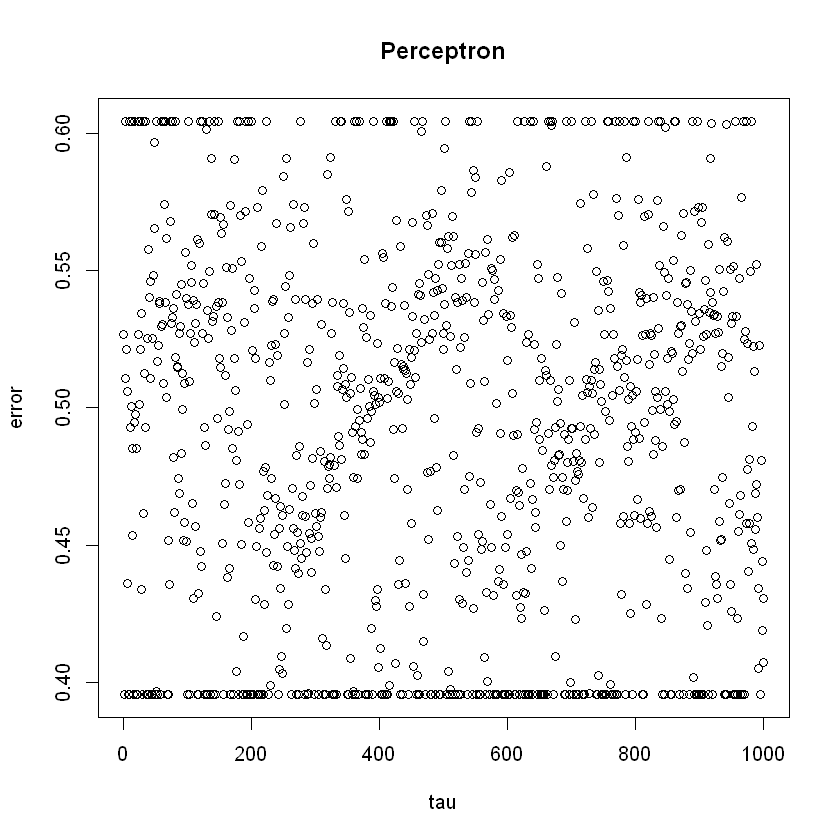

In [17]:
# run perceptron on train data
perceptron_w_1 <- perceptron.build(train$x, train$y,eta=0.1, epsilon=0.001, tau.max=1000, plotting=TRUE)
perceptron_w_1
perceptron_w_2 <- perceptron.build(train$x, train$y,eta=0.9, epsilon=0.001, tau.max=1000, plotting=TRUE)
perceptron_w_2

In [ ]:
# error rate on test data
test$y[test$y == 0] <- -1  # change label of test to -1,1
test_Phi <- as.matrix(cbind(1, test$x))  # compute phi for test data
test_error_1 <- error.rate(perceptron.predict(test_Phi, perceptron_w_1), test$y) # compute test error with model 1
test_error_2 <- error.rate(perceptron.predict(test_Phi, perceptron_w_2), test$y) # compute test error with model 2

In [19]:
# check test errors
test_error_1
test_error_2

[1] 0.5104

[1] 0.43

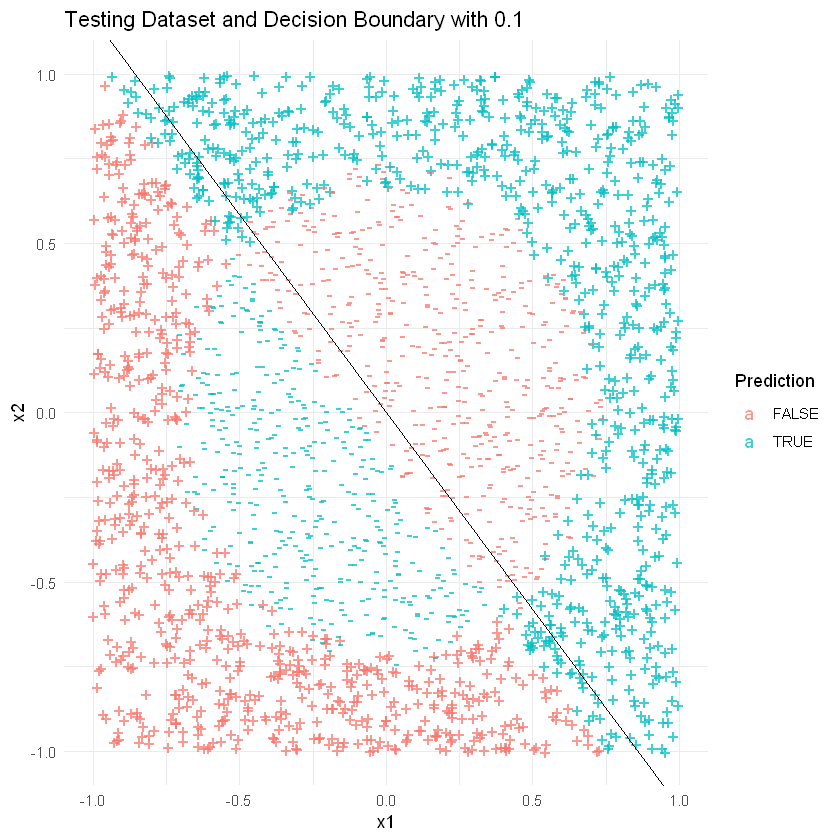

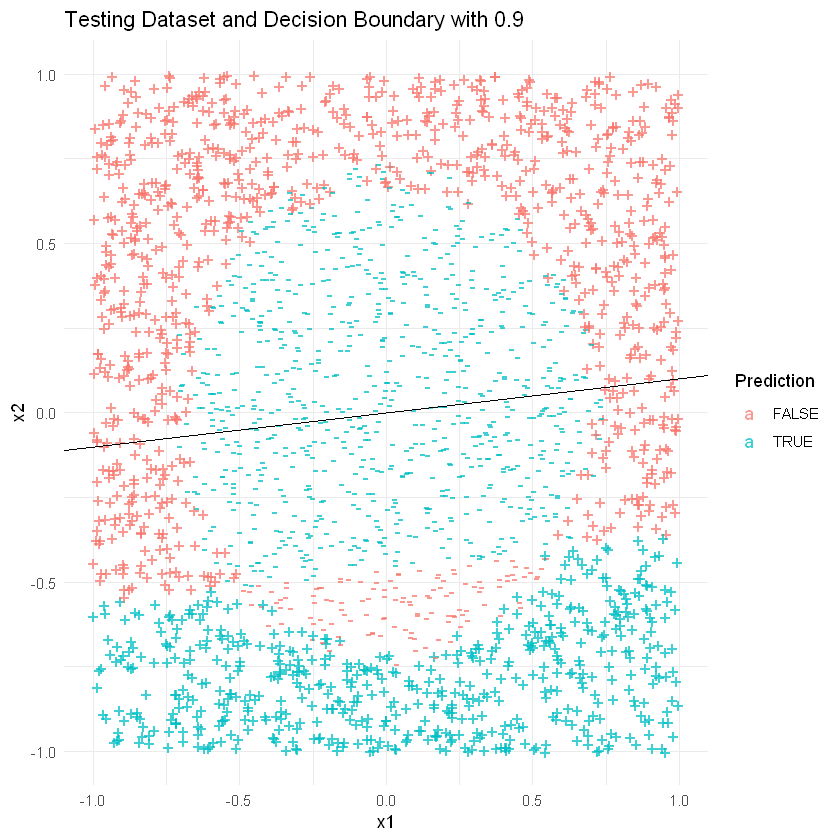

In [20]:
## Ploting the decision boundary for testing dataset using weights of two perceptron 
ggplot(data=as.data.frame(test_Phi), aes(x=x1, y=x2, label=ifelse(test$y!=1, '-', '+'), color=factor(test_Phi%*%perceptron_w_1*test$y>0))) +
    geom_text(alpha=0.75) +
    scale_color_discrete(guide = guide_legend(title = 'Prediction')) +
    geom_abline(intercept=perceptron_w_1[1], slope=-perceptron_w_1[2]/perceptron_w_1[3]) +
    ggtitle('Testing Dataset and Decision Boundary with 0.1') +
    theme_minimal()

ggplot(data=as.data.frame(test_Phi), aes(x=x1, y=x2, label=ifelse(test$y!=1, '-', '+'), color=factor(test_Phi%*%perceptron_w_2*test$y>0))) +
    geom_text(alpha=0.75) +
    scale_color_discrete(guide = guide_legend(title = 'Prediction')) +
    geom_abline(intercept=perceptron_w_2[1], slope=-perceptron_w_2[2]/perceptron_w_2[3]) +
    ggtitle('Testing Dataset and Decision Boundary with 0.9') +
    theme_minimal()

Based on test error, perceptron with learning rate of 0.9 is a better model in this case. 

For the first model with η = 0.1, after running the code a few times, it appears that the model always only have a test error rate around 0.5 where the decision boundry always appears to be a diagonal.

The second model with η = 0.9, although still have a linear decision boundry(as we are using perceptron), it has a better performance on estimation on labels and the testing errors. Where the estimations on label and decision boundry seems to make more sense compare to the previous model.

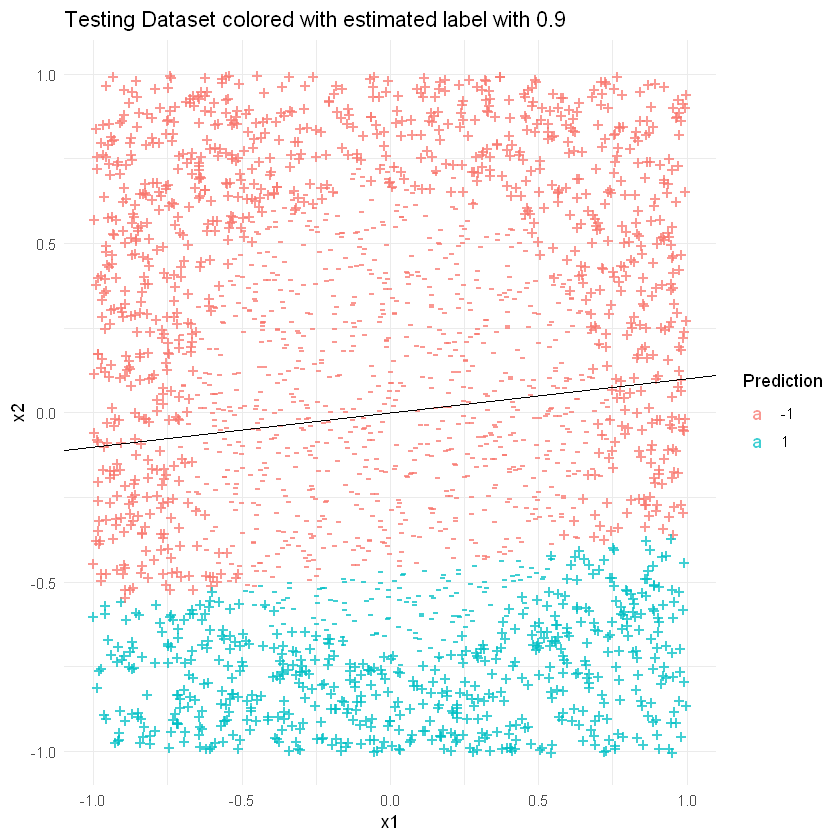

In [24]:
# plot the test data with points colored with their estimated class labels, where shape is the real label
ggplot(data=as.data.frame(test_Phi), aes(x=x1, y=x2, label=ifelse(test$y!=1, '-', '+'), color=factor(perceptron.predict(test_Phi,perceptron_w_2)))) +
    geom_text(alpha=0.75) +
    scale_color_discrete(guide = guide_legend(title = 'Prediction')) +
    geom_abline(intercept=perceptron_w_2[1], slope=-perceptron_w_2[2]/perceptron_w_2[3]) +
    ggtitle('Testing Dataset colored with estimated label with 0.9') +
    theme_minimal()

### 3. Neural Network and visualization

In [8]:
# for multiple outputs
list <- structure(NA,class="result")
"[<-.result" <- function(x,...,value) {
  args <- as.list(match.call())
  args <- args[-c(1:2,length(args))]
  length(value) <- length(args)
  for(i in seq(along=args)) {
    a <- args[[i]]
    if(!missing(a)) eval.parent(substitute(a <- v,list(a=a,v=value[[i]])))
  }
  x
}

# transform function (0:1)
h <- function(z) { 
    return ((exp(z)-exp(-z))/(exp(z)+exp(-z)))
}

## the derivitive of the activation function (tanh here)
h.d <- function(z) {
    return (1-(h(z))^2)
}

## Class Probabilities
class.prob <- function(X, W1, W2, b1, b2){
    a2 <- h(sweep(W1 %*% X, 1, b1,'+' ))
    a3 <- h(sweep(W2 %*% a2, 1, b2,'+' ))
    return (a3)
}

## prediction
nn.predict <- function(X, W1, W2, b1, b2, threshold=0){
    return (ifelse(class.prob(X, W1, W2, b1, b2)>=threshold, 1, -1))
}

## feedforward step
feedforward <- function(Xi, Ti, W1, b1, W2, b2){
    ### 1st (input) layer 
    a1 <- Xi
    y <- Ti
    ### 2nd (hidden) layer
    z2 <- W1 %*% a1 + b1
    a2 <- h(z2)        
    ### 3rd (output) layer
    z3 <- W2 %*% a2 + b2
    a3 <- h(z3)  
    return(list(a1, a2, a3, y, z2, z3))
}

## backpropagation step
backpropagation <- function(Ti, W2, z2, z3, a3){
  ### 3rd (output) layer
  d3 <- -(Ti-a3) * h.d(z3)
  ### 2nd (hidden) layer
  d2 <-  t(W2)%*%d3  * h.d (z2)
  return(list(d2,d3))
}


## NN build function
nn.build <- function(K, X1, T1, epoch.max=50, eta = 0.1, lambda = 0.01){
    # initialization
    D <- nrow(X1)
    if (D!=2) {stop('nn.predict: This simple version only accepts two dimensional data.')}
    N <- ncol(X1)
    W1 <- matrix(rnorm(D*K, sd=0.5), nrow=K, ncol=D)
    b1 <- matrix(rnorm(1*K), nrow=K, ncol=1)
    W2 <- matrix(rnorm(K*1, sd=0.5), nrow=1, ncol=K)
    b2 <- matrix(rnorm(1*1), nrow=1, ncol=1)
    
    # forward and backward and update weight in each epoch
    for (epoch in 1:epoch.max){   
        ## delta vectors/matrices initialization
        W1.d <- W1 *0
        b1.d <- b1 *0
        W2.d <- W2 *0
        b2.d <- b2 *0
        for (i in 1:N){
            ## Feedforward:
            list[a1, a2, a3, y, z2, z3] <- feedforward(X1[,i], T1[i], W1, b1, W2, b2)          
            ## Backpropagation:
            list[d2, d3] <- backpropagation(T1[i], W2, z2, z3, a3)
            ## calculate the delta values
            ### 1st layer
            W1.d <- W1.d + d2 %*% t(a1)
            b1.d <- b1.d + d2
            ### 2nd layer
            W2.d <- W2.d + d3 %*% t(a2)
            b2.d <- b2.d + d3
        }
        ## update weight vectors and matrices
        W1 <- W1 - eta * (W1.d/N + lambda*W1)
        b1 <- b1 - eta * (b1.d/N)
        W2 <- W2 - eta * (W2.d/N + lambda*W2)
        b2 <- b2 - eta * (b2.d/N)
    }
    return(list(W1, W2, b1, b2))
}


In [9]:
# assign variables
X1 <- train$x
X2 <- test$x
T1 <- train$y
T2 <- test$y
X1.t <- t(as.matrix(X1))
X2.t <- t(as.matrix(X2))

# create a dataframe to store results
error.rec <- data.frame("K" = rep(seq(5,100,5),2), "eta" = 0 , Train= 0, Test = 0)
error.rec$eta[1:20] <- 0.1
error.rec$eta[21:40] <- 0.9

In [10]:
# run nn for all k 
c <- 1
# eta = 0.1
for (k in seq(5, 100, 5)) {
    list[W1, W2, b1, b2]<- nn.build(k, X1.t, T1, epoch.max=500, eta = 0.1, lambda = 0.01)
    ## record the errors
    error.rec[c,3] <- error.rate(nn.predict(X1.t, W1, W2, b1, b2), T1)
    error.rec[c,4] <- error.rate(nn.predict(X2.t, W1, W2, b1, b2), T2)                      
    c <- c + 1
}
# eta = 0.9
for (k in seq(5, 100, 5)) {
    list[W1, W2, b1, b2]<- nn.build(k, X1.t, T1, epoch.max=500, eta = 0.9, lambda = 0.01)
    ## record the errors
    error.rec[c,3] <- error.rate(nn.predict(X1.t, W1, W2, b1, b2), T1)
    error.rec[c,4] <- error.rate(nn.predict(X2.t, W1, W2, b1, b2), T2)                      
    c <- c + 1
}

In [11]:
# check the results
error.rec

K,eta,Train,Test
<dbl>,<dbl>,<dbl>,<dbl>
5,0.1,0.2648,0.2832
10,0.1,0.0452,0.0480
15,0.1,0.0712,0.0792
20,0.1,0.0468,0.0520
25,0.1,0.0484,0.0536
30,0.1,0.0472,0.0532
35,0.1,0.0380,0.0464
40,0.1,0.0388,0.0508
45,0.1,0.0368,0.0440


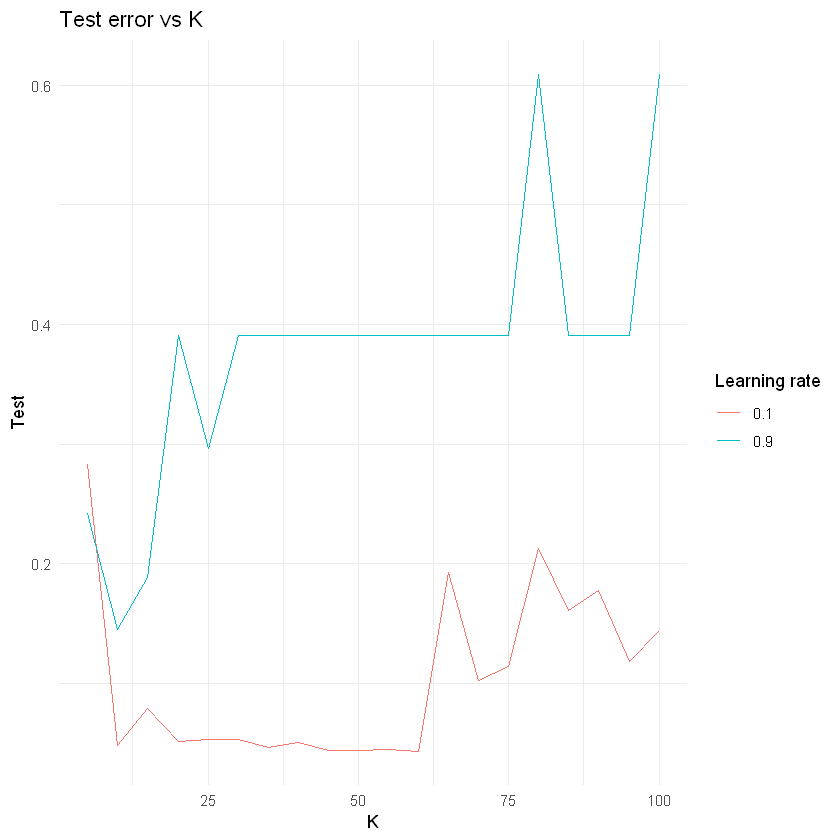

In [15]:
# plot K vs test error for two nn
ggplot(data = error.rec, aes(x = K, y = Test, color = factor(eta)))+ 
geom_line() +
scale_color_discrete(guide = guide_legend(title = 'Learning rate')) +
ggtitle('Test error vs K') +
theme_minimal()

In [27]:
# plot best model with best K
list[W1, W2, b1, b2]<- nn.build(60, X1.t, T1, epoch.max=500, eta = 0.1, lambda = 0.01)
prediction.best <- nn.predict(X2.t, W1, W2, b1, b2)

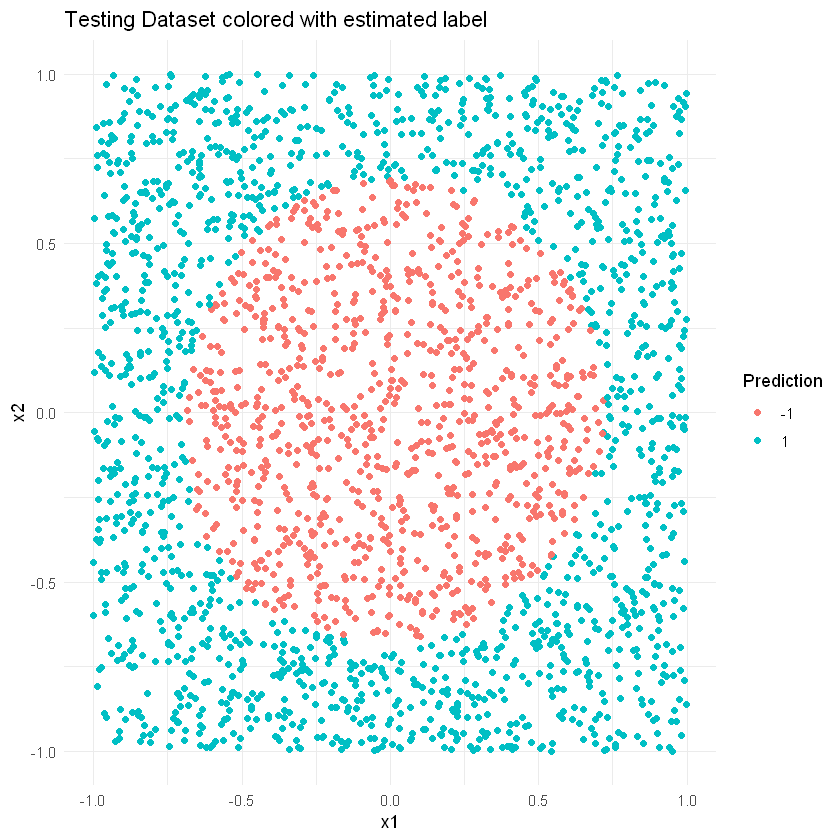

In [29]:
ggplot(data=test$x, aes(x=x1, y=x2, color=factor(prediction.best))) +
    geom_point() +
    scale_color_discrete(guide = guide_legend(title = 'Prediction')) +
    ggtitle('Testing Dataset colored with estimated label') +
    theme_minimal()